# Data Science with Python and Dask

In [1]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Chapter 2 Introducing Dask

In [2]:
df = dd.read_csv('nyc-parking-tickets/*2017.csv')

In [3]:
df

,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,Street Code3,Vehicle Expiration Date,Violation Location,Violation Precinct,Issuer Precinct,Issuer Code,Issuer Command,Issuer Squad,Violation Time,Time First Observed,Violation County,Violation In Front Of Or Opposite,House Number,Street Name,Intersecting Street,Date First Observed,Law Section,Sub Division,Violation Legal Code,Days Parking In Effect,From Hours In Effect,To Hours In Effect,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
npartitions=33,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,object,object,object,object,int64,object,object,object,int64,int64,int64,int64,float64,int64,int64,int64,object,object,object,object,object,object,object,object,object,int64,int64,object,object,object,object,object,object,float64,int64,object,int64,object,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Counting the missing values

In [4]:
missing_values = df.isnull().sum()
missing_values

Dask Series Structure:
npartitions=1
Date First Observed    int64
Violation Time           ...
dtype: int64
Dask Name: dataframe-sum-agg, 100 tasks

In [5]:
missing_count = (missing_values/df.index.size)*100
missing_count

Dask Series Structure:
npartitions=1
Date First Observed    float64
Violation Time             ...
dtype: float64
Dask Name: mul, 169 tasks

In [7]:
with ProgressBar():
    missing_count_pct = missing_count.compute()
missing_count_pct

[##################################      ] | 86% Completed | 51.5s

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/multiprocessing/pool.py:119: DtypeWarning: Columns (18,38) have mixed types.Specify dtype option on import or set low_memory=False.
  result = (True, func(*args, **kwds))


[########################################] | 100% Completed | 54.1s


Summons Number                         0.000000
Plate ID                               0.006739
Registration State                     0.000000
Plate Type                             0.000000
Issue Date                             0.000000
Violation Code                         0.000000
Vehicle Body Type                      0.395361
Vehicle Make                           0.676199
Issuing Agency                         0.000000
Street Code1                           0.000000
Street Code2                           0.000000
Street Code3                           0.000000
Vehicle Expiration Date                0.000000
Violation Location                    19.183510
Violation Precinct                     0.000000
Issuer Precinct                        0.000000
Issuer Code                            0.000000
Issuer Command                        19.093212
Issuer Squad                          19.101506
Violation Time                         0.000583
Time First Observed                   92

## 2.5 Filtering sparse columns

In [30]:
columns_to_drop = missing_count_pct[missing_count_pct>60].index
with ProgressBar():
    df_dropped = df.drop(columns_to_drop, axis=1).persist()

[################################        ] | 81% Completed | 44.1s

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/dask/core.py:121: DtypeWarning: Columns (18,38) have mixed types.Specify dtype option on import or set low_memory=False.
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 46.5s


### get the shape of df_dropped

In [37]:
df_dropped_shape = df_dropped.shape
df_shape = [0, df_dropped_shape[1]]
with ProgressBar():
    df_shape[0] = df_dropped_shape[0].compute()
df_shape

[########################################] | 100% Completed |  0.1s


[10803028, 35]

## 2.6 Creating some functions

In [2]:
import dask.delayed as delayed

In [3]:
def inc(i): return i+1
def add(x, y): return x + y

In [27]:
x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

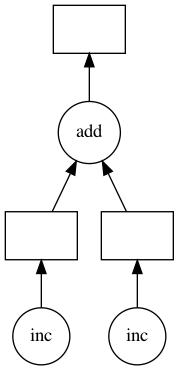

In [28]:
z.visualize(format='png')

In [21]:
z.compute()

5

In [25]:
z

Delayed('add-e291c50c-42ff-4c8a-b146-579d96288538')

In [43]:
#missing_count.visualize()

# Chapter 5 Cleaning and Transforming Dataframes

In [29]:
dtypes = {
 'Date First Observed': np.str,
 'Days Parking In Effect    ': np.str,
 'Double Parking Violation': np.str,
 'Feet From Curb': np.float32,
 'From Hours In Effect': np.str,
 'House Number': np.str,
 'Hydrant Violation': np.str,
 'Intersecting Street': np.str,
 'Issue Date': np.str,
 'Issuer Code': np.float32,
 'Issuer Command': np.str,
 'Issuer Precinct': np.float32,
 'Issuer Squad': np.str,
 'Issuing Agency': np.str,
 'Law Section': np.float32,
 'Meter Number': np.str,
 'No Standing or Stopping Violation': np.str,
 'Plate ID': np.str,
 'Plate Type': np.str,
 'Registration State': np.str,
 'Street Code1': np.uint32,
 'Street Code2': np.uint32,
 'Street Code3': np.uint32,
 'Street Name': np.str,
 'Sub Division': np.str,
 'Summons Number': np.uint32,
 'Time First Observed': np.str,
 'To Hours In Effect': np.str,
 'Unregistered Vehicle?': np.str,
 'Vehicle Body Type': np.str,
 'Vehicle Color': np.str,
 'Vehicle Expiration Date': np.str,
 'Vehicle Make': np.str,
 'Vehicle Year': np.float32,
 'Violation Code': np.uint16,
 'Violation County': np.str,
 'Violation Description': np.str,
 'Violation In Front Of Or Opposite': np.str,
 'Violation Legal Code': np.str,
 'Violation Location': np.str,
 'Violation Post Code': np.str,
 'Violation Precinct': np.float32,
 'Violation Time': np.str
}


In [30]:
nyc_data_raw = dd.read_csv('nyc-parking-tickets/*.csv', dtype=dtypes, usecols=dtypes.keys())

## 5.1 Working with indexes and axes

In [31]:
with ProgressBar():
    display(nyc_data_raw['Plate ID'].head())

[########################################] | 100% Completed |  1.7s


0    GBB9093
1    62416MB
2    78755JZ
3    63009MA
4    91648MC
Name: Plate ID, dtype: object

In [34]:
with ProgressBar():
    print(nyc_data_raw['Plate ID'].head())

[########################################] | 100% Completed |  1.7s
0    GBB9093
1    62416MB
2    78755JZ
3    63009MA
4    91648MC
Name: Plate ID, dtype: object


### listing 5.2 Selecting multiple columns from a dataframe

In [76]:
nyc_data_2cols = nyc_data_raw[['Plate ID', 'Registration State']]
with ProgressBar():
    print(nyc_data_2cols.head())

[########################################] | 100% Completed |  1.6s
  Plate ID Registration State
0  GBB9093                 NY
1  62416MB                 NY
2  78755JZ                 NY
3  63009MA                 NY
4  91648MC                 NY


In [71]:
with ProgressBar():
    display(nyc_data_raw.drop('Violation Code', axis=1).head())

[########################################] | 100% Completed |  1.8s


,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,Street Code2,...,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
0,1283294138,GBB9093,NY,PAS,08/04/2013,SUBN,AUDI,P,37250,13610,...,GY,0,2013.0,-,0.0,NaN,NaN,NaN,NaN,NaN
1,1283294151,62416MB,NY,COM,08/04/2013,VAN,FORD,P,37290,40404,...,WH,0,2012.0,-,0.0,NaN,NaN,NaN,NaN,NaN
2,1283294163,78755JZ,NY,COM,08/05/2013,P-U,CHEVR,P,37030,31190,...,NaN,0,0.0,-,0.0,NaN,NaN,NaN,NaN,NaN
3,1283294175,63009MA,NY,COM,08/05/2013,VAN,FORD,P,37270,11710,...,WH,0,2010.0,-,0.0,NaN,NaN,NaN,NaN,NaN
4,1283294187,91648MC,NY,COM,08/08/2013,TRLR,GMC,P,37240,12010,...,BR,0,2012.0,-,0.0,NaN,NaN,NaN,NaN,NaN


### listing 5.8 Getting a single row by index

In [36]:
with ProgressBar():
    display(nyc_data_raw.loc[56].head(1))

[########################################] | 100% Completed |  1.6s


,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
56,1293090530,GES3519,NY,PAS,07/07/2013,40,SDN,HONDA,F,70630,...,BLACK,0,1997.0,-,0.0,NaN,NaN,NaN,NaN,NaN


### listing 5.10 Filtering a slice of rows using Dask and Pandas

In [37]:
with ProgressBar():
    some_rows = nyc_data_raw.loc[100:200].head(100)
some_rows.drop(range(100,200,2))

[########################################] | 100% Completed |  1.6s


,Summons Number,Plate ID,Registration State,Plate Type,Issue Date,Violation Code,Vehicle Body Type,Vehicle Make,Issuing Agency,Street Code1,...,Vehicle Color,Unregistered Vehicle?,Vehicle Year,Meter Number,Feet From Curb,Violation Post Code,Violation Description,No Standing or Stopping Violation,Hydrant Violation,Double Parking Violation
101,1294727461,R613159,IL,PAS,07/17/2013,17,SDN,VOLKS,P,14510,...,BLUE,0,0.0,-,0.0,NaN,NaN,NaN,NaN,NaN
103,1294727497,ZWZ43K,NJ,PAS,08/10/2013,17,SUBN,LINCO,P,14510,...,NaN,0,0.0,-,0.0,NaN,NaN,NaN,NaN,NaN
105,1295546486,42909JM,NY,COM,07/17/2013,19,DELV,MERCU,P,58590,...,BROWN,0,1996.0,-,0.0,NaN,NaN,NaN,NaN,NaN
107,1302446484,452WW4,MA,PAS,06/24/2013,46,SDN,CHEVR,C,75530,...,YELLO,0,2013.0,-,0.0,NaN,NaN,NaN,NaN,NaN
109,1302453774,GEX5296,NY,PAS,07/26/2013,14,SDN,ME/BE,C,36420,...,BLACK,0,0.0,-,0.0,NaN,NaN,NaN,NaN,NaN
111,1302453798,867ZFX,CT,PAS,07/15/2013,17,SDN,ACURA,C,0,...,WHITE,0,0.0,-,0.0,NaN,NaN,NaN,NaN,NaN
113,1302456593,GEZ1408,NY,PAS,07/15/2013,17,SUBN,HYUND,X,77730,...,BLK,0,2013.0,-,0.0,NaN,NaN,NaN,NaN,NaN
115,1302456738,UCSLIM,NY,PAS,08/07/2013,17,SUBN,FORD,X,77730,...,BLK,0,2003.0,-,0.0,NaN,NaN,NaN,NaN,NaN
117,1302466203,HPM2636,PA,PAS,08/08/2013,40,SUBN,CADIL,X,24245,...,SILVR,0,0.0,-,0.0,NaN,NaN,NaN,NaN,NaN
119,1302466227,TWODAMAX,NY,SRF,08/05/2013,17,SDN,HYUND,X,53630,...,GRAY,0,2012.0,-,0.0,NaN,NaN,NaN,NaN,NaN


## 5.2 Dealing with missing values

### listing 5.11 Calculating the percentage of the missing values by column

In [40]:
missing_values = nyc_data_raw.isnull().sum()

In [41]:
with ProgressBar():
    percent_missing = ((missing_values / nyc_data_raw.index.size) * 100).compute()
percent_missing

[########################################] | 100% Completed |  3min 53.4s


Summons Number                        0.000000
Plate ID                              0.020867
Registration State                    0.000000
Plate Type                            0.000000
Issue Date                            0.000000
Violation Code                        0.000000
Vehicle Body Type                     0.564922
Vehicle Make                          0.650526
Issuing Agency                        0.000000
Street Code1                          0.000000
Street Code2                          0.000000
Street Code3                          0.000000
Vehicle Expiration Date               0.000002
Violation Location                   15.142846
Violation Precinct                    0.000002
Issuer Precinct                       0.000002
Issuer Code                           0.000002
Issuer Command                       15.018851
Issuer Squad                         15.022566
Violation Time                        0.019207
Time First Observed                  90.040886
Violation Cou

In [46]:
percent_missing.index

Index(['Summons Number', 'Plate ID', 'Registration State', 'Plate Type',
       'Issue Date', 'Violation Code', 'Vehicle Body Type', 'Vehicle Make',
       'Issuing Agency', 'Street Code1', 'Street Code2', 'Street Code3',
       'Vehicle Expiration Date', 'Violation Location', 'Violation Precinct',
       'Issuer Precinct', 'Issuer Code', 'Issuer Command', 'Issuer Squad',
       'Violation Time', 'Time First Observed', 'Violation County',
       'Violation In Front Of Or Opposite', 'House Number', 'Street Name',
       'Intersecting Street', 'Date First Observed', 'Law Section',
       'Sub Division', 'Violation Legal Code', 'Days Parking In Effect    ',
       'From Hours In Effect', 'To Hours In Effect', 'Vehicle Color',
       'Unregistered Vehicle?', 'Vehicle Year', 'Meter Number',
       'Feet From Curb', 'Violation Post Code', 'Violation Description',
       'No Standing or Stopping Violation', 'Hydrant Violation',
       'Double Parking Violation'],
      dtype='object')

### listing 5.12 Dropping columns that have more than 50% missing values

In [47]:
columns_to_drop = list(percent_missing[percent_missing >= 50].index)
nyc_data_clean_stage1 = nyc_data_raw.drop(columns_to_drop, axis=1)

In [48]:
columns_to_drop

['Time First Observed',
 'Intersecting Street',
 'Violation Legal Code',
 'Unregistered Vehicle?',
 'Meter Number',
 'No Standing or Stopping Violation',
 'Hydrant Violation',
 'Double Parking Violation']